# RNN Name classification

Let's try the exercise from this pytorch tutorial:

[https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

We've already downloaded and curated the data.

The raw data contains a set of files, where the file name is a country; and each line of the file is a name originating from that country.

The challenge is use an RNN that reads letter-by-letter and classifies a name according to its country of origin.

We've processed the raw data so that we now have two files: `names_indices.txt` and `countries_word_indices.txt`. In the former, we've tokenized each name into its component letters, not transforming to lowercase, and then converted each token to its index in the vocabulary. We also added sos/eos tokens on the front and end of the names. In the latter, we've done the same process but treated the whole name of the country as a token and didn't wrap it with special tokens.

Let's play with PyTorch Lightning. We'll run this classification problem 3 times, having the base RNN be a vanilla RNN, an LSTM, and a GRU. We'll take a look at the metrics logged with Tensorboard to see if there's a big difference.

## Libraries

In [1]:
import os
import numpy as np
import yaml

import torch
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning import seed_everything

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt

from common.language import load_language

from common.dataloaders import (
    TranslationDataset,
    padding_collator,
)

from common.models import (
    RNNClassifier,
)

from common.utils import (
    get_logger,
    Timer,
)

logger = get_logger("name_classification")

## Parameters

In [2]:
# Set seed
seed_everything(2718)

# Set the cwd to the root of the project.
# Only let this execute once
if os.getcwd().endswith("src"):
    os.chdir("..")

logger.info(f"Current working directory: {os.getcwd()}")

2024-10-14 20:59:53 - name_classification - INFO: Current working directory: /home/rob/encoder-decoder


In [3]:
# Load config.yaml. This contains all of our paths and constants.
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Training params
EPOCHS = 10
BATCH_SIZE = 128
EMBEDDING_SIZE = 512
HIDDEN_SIZE = 512
NUM_LAYERS = 1
DROPOUT = 0.0  # Dropout is between rnn layers

# Trainer params
UNIT_TYPE = "GRU"  # GRU or LSTM or RNN
ACCELERATOR = "gpu"  # "cpu" or "gpu"

# CPUS to give each dataloader
NUM_WORKERS = 3

# Every time you run training, the logs will have this tag attached.
# If you rerun with the same tag, the log will be overwritten.
TAG = (
    f"UNIT={UNIT_TYPE}_"
    f"BATCH_SIZE={BATCH_SIZE}_"
    f"EMBEDDING_SIZE={EMBEDDING_SIZE}_"
    f"HIDDEN_SIZE={HIDDEN_SIZE}_"
    f"LAYERS={NUM_LAYERS}_"
    f"DROPOUT={DROPOUT}_"
)

In [4]:
# Load the language models
names_language = load_language(config["NAMES_LANGUAGE_MODEL_PATH"])

# Use the country model where we didn't split up the word into letters.
countries_language = load_language(config["COUNTRIES_WORD_LANGUAGE_MODEL_PATH"])

In [5]:
NAMES_VOCAB_SIZE = len(names_language.vocabulary)
COUNTRIES_VOCAB_SIZE = len(countries_language.vocabulary)

print(f"Names vocab size: {NAMES_VOCAB_SIZE}")
print(f"Countries vocab size: {COUNTRIES_VOCAB_SIZE}")

# Vocabulary attributes are a dictionary with the token being the
# key and the index being how frequently the token appears in the corpus.
# Note that since we've added the special tokens ourselves, they will
# have frequency 0.
name_vocab = list(names_language.vocabulary.keys())
country_vocab = list(countries_language.vocabulary.keys())

print("Top 10 most common tokens in names vocabulary:")
for i in range(10):
    print(f"{name_vocab[i]}: {names_language.vocabulary[name_vocab[i]]}")

print("\nTop 10 most common tokens in countries vocabulary:")
for i in range(10):
    print(
        f"{country_vocab[i]}: {countries_language.vocabulary[country_vocab[i]]}"
    )

Names vocab size: 91
Countries vocab size: 19
Top 10 most common tokens in names vocabulary:
<PAD>: 0
<UNK>: 0
<SOS>: 0
<EOS>: 0
a: 11339
o: 8849
i: 8625
e: 8359
n: 8158
r: 6841

Top 10 most common tokens in countries vocabulary:
Russian: 9408
English: 3668
Arabic: 2000
Japanese: 991
German: 724
Italian: 709
Czech: 519
Spanish: 298
Dutch: 297
French: 277


We see that there's some class imbalance. Russian names dominate this data set.

## Dataset and Dataloader

In [6]:
dataset = TranslationDataset(
    source_labels_path=config["NAMES_INPUT_PATH"],
    target_labels_path=config["COUNTRIES_INPUT_PATH"],
    source_indices_path=config["NAMES_OUTPUT_PATH"],
    target_indices_path=config["COUNTRIES_WORD_OUTPUT_PATH"],
)

In [7]:
# Show random example
x, y, name, country = dataset[np.random.randint(0, len(dataset))]
print("Input: ", x)
print("Target: ", y)
print("Name: ", name)
print("Country: ", country)

# Note that the input always begins with 2 <SOS> and ends with 3 <EOS>

Input:  tensor([ 2, 39,  4,  8,  7,  3])
Target:  tensor([1])
Name:  Vane
Country:  English


In [8]:
train_data, val_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [9]:
# Create the dataloaders
# We use a collate function to pad the sequences to the same length.

train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=padding_collator,
)

val_dataloader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=padding_collator,
)

In [10]:
# Get a batch from the dataloader
x, y, names, countries = next(iter(train_dataloader))

print(x.shape)
print(y.shape)
print(names)
print(countries)

torch.Size([128, 19])
torch.Size([128, 1])
['Miheikin', 'Neverkovich', 'Chekmenev', 'Sabbag', 'Yatsuba', 'Bagmut', 'Kawakami', 'Sarraf', 'Chuhnin', 'Bakalov', 'Yuzefovich', 'Barker', 'Vela', 'Saifullin', 'Adelung', 'Chizhevsky', 'Adjaloff', 'Tcheh', 'Hawtin', 'Dijin', 'Clements', 'Shenshin', 'Chekharin', 'Hideki', 'Thach', 'Juhanaev', 'Prigozhin', 'Bassin', 'Marik', 'Ryzhkovsky', 'Kenney', 'Jebelev', 'Pannell', 'Takagawa', 'Galkov', 'Jedrinsky', 'Vedyakin', 'Hanaev', 'Eales', 'Chuhraev', 'Rose', 'Maksyutenko', 'Vilmont', 'Habarov', 'Hakhanyan', 'Chukhrov', 'Luss', 'Jacks', 'Granatkin', 'Glasgow', 'Talypin', 'Vyazmikin', 'Abboud', 'Reier', 'Luskanov', 'Prigorodov', 'Shamon', 'Djanaev', 'Hudabirdin', 'Kitao', 'Yamakage', 'Judenkov', 'Prehatney', 'Beider', 'Ludwig', 'Deeb', 'Khouri', 'Davy', 'Asker', 'Owen', 'Otaka', 'Jeleznyakov', 'Varakin', 'Jamburg', 'Blanco', 'Forsyth', 'Said', 'Dressler', 'Marchioni', 'Jakhnyuk', 'Huynh', 'Yorston', 'Laraway', 'Verstin', 'Katz', 'Gehtman', 'Trevor', 

## Model

In [11]:
model = RNNClassifier(
    input_size=NAMES_VOCAB_SIZE,
    output_size=COUNTRIES_VOCAB_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    unit_type=UNIT_TYPE,
    epochs=EPOCHS,
    data_length=len(train_data),
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
)

In [12]:
# Check that we can forward pass with the x generated above.

output, hidden = model(x)

print(f"Output shape: {output.shape}")

# If hidden is a tuple, then it came from an LSTM.
# Split it up into the hidden and cell states.
if isinstance(hidden, tuple):
    hidden, cell = hidden

print(f"Hidden shape: {hidden.shape}")

# Output is (batch, seq_len, output_size)
# Hidden is (num_layers, batch, hidden_size)

Output shape: torch.Size([128, 19, 19])
Hidden shape: torch.Size([1, 128, 512])


In [13]:
# Print how many parameters the model has
print(
    f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters."
)

Model has 1,632,275 parameters.


## Training

In [14]:
# Training logs

tensorboard_logger = TensorBoardLogger(
    save_dir=config["TENSORBOARD_LOGS_PATH"],
    name="name-classification/",
    version=TAG,
)

In [15]:
# Use our nominated accelerator and log to tensorboard
trainer = L.Trainer(
    devices=1,
    accelerator=ACCELERATOR,
    logger=tensorboard_logger,
    max_epochs=EPOCHS,
)

In [16]:
timer = Timer()
trainer.fit(model, train_dataloader, val_dataloader)
print(f"Elapsed time: {timer.toc()}")

/home/rob/encoder-decoder/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1:   0%|          | 0/126 [00:00<?, ?it/s, v_num=0.0_]           

/home/rob/encoder-decoder/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 46. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 9: 100%|██████████| 126/126 [00:01<00:00, 95.20it/s, v_num=0.0_] 
Elapsed time: 00:00:13


In [17]:
model.freeze()
trainer.test(model, val_dataloader)

Testing DataLoader 0: 100%|██████████| 32/32 [00:00<00:00, 236.42it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8303437829017639     │
│         test_loss         │    0.5955110192298889     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5955110192298889, 'test_accuracy': 0.8303437829017639}]

In [18]:
# Save the model
torch.save(model.state_dict(), config["NAME_CLASSIFICATION_TORCH_MODEL_PATH"])

## Evaluation

In [19]:
# run the model over the validation set to get actual and predicted.
# Can probably do this more efficiently

model.eval()
actual = []
predicted = []

for x, y, name, country in val_data:
    output, _ = model(x.unsqueeze(0))

    # Pull out the output fir the last token
    output = output[:, -1, :]

    # argmax to get the index of the highest value
    predicted_country_index = torch.argmax(output).item()

    # Use the language model to get the country name
    predicted_country = countries_language.index_to_token(
        predicted_country_index
    )

    actual.append(country)
    predicted.append(predicted_country)

In [20]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

      Arabic       0.96      1.00      0.98       410
     Chinese       0.75      0.63      0.68        62
       Czech       0.47      0.36      0.41       106
       Dutch       0.45      0.65      0.53        60
     English       0.85      0.63      0.72       762
      French       0.22      0.44      0.29        45
      German       0.55      0.52      0.54       146
       Greek       0.31      0.81      0.45        37
       Irish       0.21      0.66      0.32        50
     Italian       0.64      0.78      0.71       143
    Japanese       0.83      0.93      0.88       196
      Korean       0.29      0.22      0.25        18
      Polish       0.66      0.58      0.61        33
  Portuguese       0.12      0.08      0.10        12
     Russian       0.94      0.93      0.94      1838
    Scottish       0.08      0.04      0.05        26
     Spanish       0.47      0.28      0.35        58
  Vietnamese       0.50    

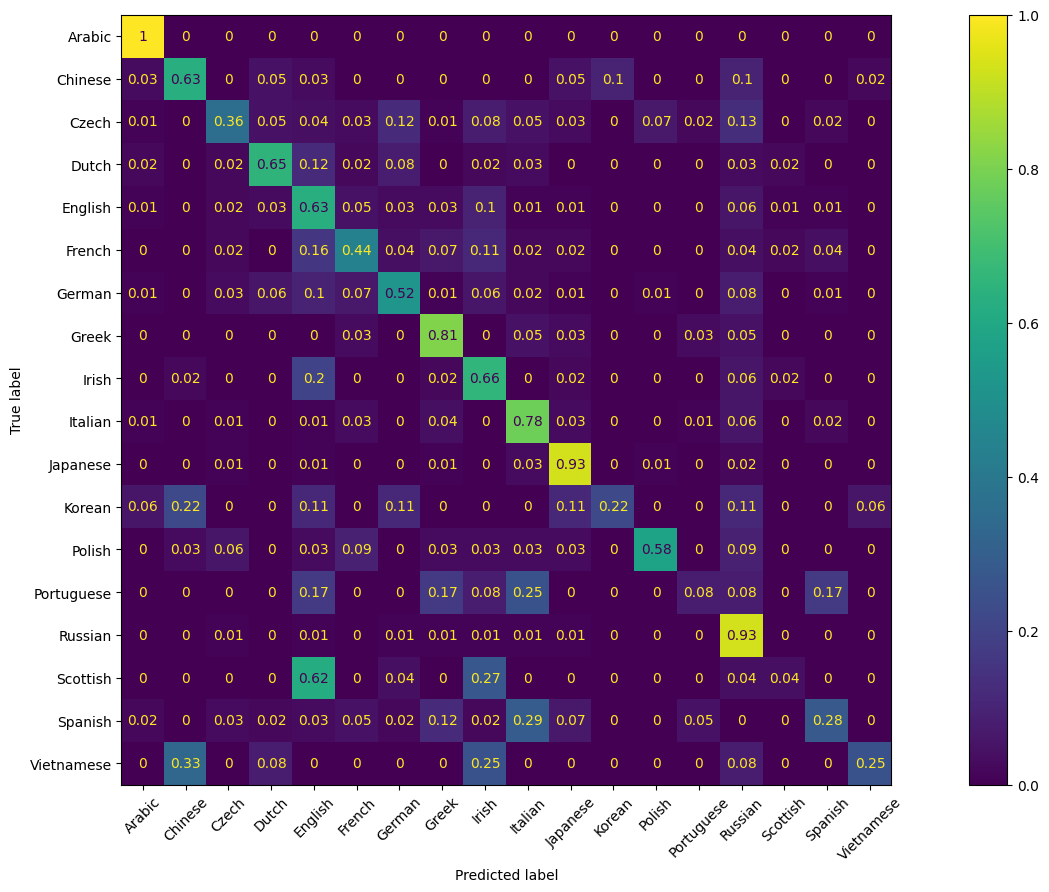

In [21]:
labels = sorted(list(set(actual).union(set(predicted))))
cm = confusion_matrix(actual, predicted, labels=labels, normalize="true")
cm = np.round(cm, 2)

plt.figure(figsize=(20, 10))
ax = plt.gca()

ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax)
plt.xticks(rotation=45)

plt.show()